# Optimize the Number of Topics for LDA

We harness the power of data visualization and use the package pyLDAvis for this task. 

In [20]:
# general:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time # will be use to choose the faster solution

# to visualize LDA topics
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle # to save models, for instance LDA outputs

from sklearn.decomposition import LatentDirichletAllocation # LDA



In [2]:
# load the data
winedata = pd.read_csv('../data/winedata_processed_and_tokenized.csv')
print(winedata.shape)
winedata.columns

(106873, 15)


Index(['index', 'country', 'description', 'designation', 'points', 'price',
       'province', 'region_1', 'region_2', 'taster_name', 'title', 'variety',
       'winery', 'tokenized_descriptions', 'token_descr_as_string'],
      dtype='object')

We first use tf-idf vectors to train the LDA. However, it seems that topic modelling, in particular LDA, does not require tf-idf vectors and might even prefer tf (BoW) vectors (c.f. [this discussion](https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model/44789327#44789327)). Thus later in the notebook, we do the same with a CountVectorizer instead.  

In [3]:
# vectorization on BIGRAMS using tf-idf :
time0 = time.time()

# note: we only keep 2000 features:
tfidf_bigram_vectorizer = TfidfVectorizer(ngram_range=(1,2), # unigram and bigram (min, max)
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tfidf_bigram = tfidf_bigram_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_tfidf_bigram = tfidf_bigram_vectorizer.get_feature_names()

# store the features in a dataframe:
tfidf_bigram_features = pd.DataFrame(wine_tfidf_bigram.toarray(), columns=terms_tfidf_bigram)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 7.502072811126709 seconds.


### Try different number of topics

We run several iterations, with a different number of topics and store the results as pickles.  


In [4]:
# THIS CHUNK TAKES TIME ! 
time0 = time.time()

all_ntopics = [4,5,6,7,8,10,20,30,50]

results = pd.DataFrame(all_ntopics, columns=['ntopics'], index=all_ntopics)

for ntopics in all_ntopics:
    lda = LatentDirichletAllocation(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )
    # the results are stored in a dataframe, with the number of topics as index:
    results.loc[ntopics, 'LDA'] = lda.fit(wine_tfidf_bigram)
    
    # we store some "metrics": 
    # Log Likelyhood: Higher the better
    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    results.loc[ntopics, 'LL'] = results.loc[ntopics, 'LDA'].score(wine_tfidf_bigram)
    results.loc[ntopics, 'perplexity'] = results.loc[ntopics, 'LDA'].perplexity(wine_tfidf_bigram)

print('Done! It took', time.time()-time0, 'seconds.')


Done! It took 902.7909979820251 seconds.


In [5]:
# overview of results:
results

ntopics                                                LDA            LL  \
4         4  LatentDirichletAllocation(batch_size=128, doc_... -3.367984e+06   
5         5  LatentDirichletAllocation(batch_size=128, doc_... -3.403539e+06   
6         6  LatentDirichletAllocation(batch_size=128, doc_... -3.410656e+06   
7         7  LatentDirichletAllocation(batch_size=128, doc_... -3.423087e+06   
8         8  LatentDirichletAllocation(batch_size=128, doc_... -3.425000e+06   
10       10  LatentDirichletAllocation(batch_size=128, doc_... -3.456007e+06   
20       20  LatentDirichletAllocation(batch_size=128, doc_... -3.530985e+06   
30       30  LatentDirichletAllocation(batch_size=128, doc_... -3.611218e+06   
50       50  LatentDirichletAllocation(batch_size=128, doc_... -3.758479e+06   

     perplexity  
4   1467.352982  
5   1584.757648  
6   1609.363521  
7   1653.264774  
8   1660.125526  
10  1775.385272  
20  2088.266293  
30  2484.390781  
50  3417.220190

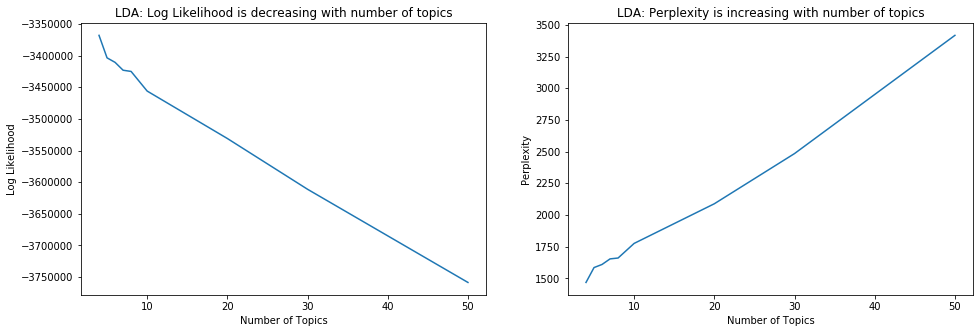

In [6]:
# plot likelihood and perplexity:
p, axes = plt.subplots(1, 2, figsize=(16,5))

p = sns.lineplot(x="ntopics", y='LL', data=results, ax=axes[0])
axes[0].title.set_text('LDA: Log Likelihood is decreasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Log Likelihood')

p = sns.lineplot(x="ntopics", y='perplexity', data=results, ax=axes[1])
axes[1].title.set_text('LDA: Perplexity is increasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Perplexity')

plt.show()

In [7]:
# SAVE ALL THESE OUTPUTS !!!

for ntopics in all_ntopics:
    # Save to file:
    pkl_filename = '../data/pickle_LDA_' + str(ntopics) + 't.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(results.loc[ntopics, 'LDA'], file)

#### All the plots !

! takes time to run too...

**About pyLDAvis**:  
The area of the topic circles is _topic prevalence_, i.e. measures the importance of the topics, relative to the data. The number are displayed in order, 1 being the most popular topic. The distance between two topics represents their similarity (in 2D instead of 300D).   

By hovering above a words, we can see its relative prevalence in the different topics (i.e. conditional topic distribution).   

Adjusting lambda (relevance metrics) helps interpreting the topic. Lambda=0 shows "jargon" specific to the topic, words that are exclusively popular (high tf-idf) for this topic. If you increase lambda, you see more blue bars, more words that are also included in other topics appear in the top 30. Playing with the balance helps interpreting the topic.  

Saliency: a measure of how much the term tells you about the topic.  

Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.  





In [9]:
# 4 topics:
pyLDAvis.sklearn.prepare(results.loc[4, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA') # or mds='mmds'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.149114 -0.103651       1        1  27.720164
1     -0.042290 -0.035368       2        1  27.118569
2     -0.042092  0.179297       3        1  24.524412
0      0.233497 -0.040277       4        1  20.636855, topic_info=     Category         Freq      Term        Total  loglift  logprob
804   Default  1842.000000    fruits  1842.000000  30.0000  30.0000
91    Default  1543.000000     apple  1543.000000  29.0000  29.0000
1285  Default  1014.000000     peach  1014.000000  28.0000  28.0000
1438  Default   976.000000     ready   976.000000  27.0000  27.0000
574   Default  2964.000000     drink  2964.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
1642   Topic4   656.905594      soft  1797.229245   0.5716  -4.9775
214    Topic4   621.792806     black  2753.996119   0.0899  -5.0325
856    Topic4   474.829896     great   849.007310   0.9970  -5.3021
768    Topic4   550.067649     fresh  1816.299227   0.3836  -5.1550
165    Topic4   504.154559  balanced  1218.317239   0.6957  -5.2422

[320 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
21        1  0.105223        acidity
21        2  0.137108        acidity
21        3  0.281869        acidity
21        4  0.476053        acidity
25        4  0.995072  acidity crisp
...     ...       ...            ...
1991      1  0.074933          young
1991      2  0.285762          young
1991      3  0.046992          young
1991      4  0.593115          young
1998      2  0.997600            zin

[564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [10]:
# 5 topics:
pyLDAvis.sklearn.prepare(results.loc[5, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA') 

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.177251  0.013016       1        1  25.539364
4      0.010665  0.154277       2        1  22.145030
2      0.033492 -0.168132       3        1  21.469437
1     -0.099413 -0.018371       4        1  16.950097
0      0.232507  0.019210       5        1  13.896073, topic_info=     Category         Freq         Term        Total  loglift  logprob
91    Default  1555.000000        apple  1555.000000  30.0000  30.0000
475   Default  1694.000000        crisp  1694.000000  29.0000  29.0000
1438  Default  1006.000000        ready  1006.000000  28.0000  28.0000
1439  Default   885.000000  ready drink   885.000000  27.0000  27.0000
198   Default  1874.000000        berry  1874.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
165    Topic5   392.916838     balanced  1223.072142   0.8380  -5.0960
777    Topic5   561.308195        fruit  3808.947158   0.0587  -4.7393
51     Topic5   341.653566          age   936.430940   0.9653  -5.2358
91     Topic5   350.899452        apple  1555.020840   0.4848  -5.2091
1442   Topic5   356.093754          red  2331.441159   0.0945  -5.1944

[404 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
21        1  0.098040        acidity
21        2  0.177165        acidity
21        3  0.234854        acidity
21        4  0.104344        acidity
21        5  0.385853        acidity
...     ...       ...            ...
1987      5  0.888846   yellow fruit
1988      5  0.995684  yellow fruits
1998      1  0.014369            zin
1998      2  0.919605            zin
1998      4  0.067055            zin

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

In [11]:
# 6 topics:
pyLDAvis.sklearn.prepare(results.loc[6, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA') 

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.059464 -0.046701       1        1  22.904825
2      0.017573  0.196604       2        1  20.001485
3      0.201506 -0.072184       3        1  17.779212
1      0.107573  0.016364       4        1  15.767691
5     -0.168162 -0.168675       5        1  12.654260
0     -0.217954  0.074591       6        1  10.892528, topic_info=     Category         Freq        Term        Total  loglift  logprob
804   Default  1876.000000      fruits  1876.000000  30.0000  30.0000
91    Default  1541.000000       apple  1541.000000  29.0000  29.0000
1784  Default  2888.000000     tannins  2888.000000  28.0000  28.0000
475   Default  1686.000000       crisp  1686.000000  27.0000  27.0000
574   Default  3003.000000       drink  3003.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
1458   Topic6   237.879872  refreshing   566.885964   1.3487  -5.3543
777    Topic6   408.385510       fruit  3814.595404  -0.0173  -4.8138
165    Topic6   290.084496    balanced  1224.251204   0.7772  -5.1559
1863   Topic6   284.701112       touch  1154.467546   0.8171  -5.1746
1946   Topic6   265.355735       white  1343.367147   0.5952  -5.2450

[469 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
21        1  0.095267        acidity
21        2  0.219773        acidity
21        3  0.072943        acidity
21        4  0.091179        acidity
21        5  0.221031        acidity
...     ...       ...            ...
1987      6  0.893438   yellow fruit
1988      6  0.993783  yellow fruits
1998      1  0.956326            zin
1998      3  0.004879            zin
1998      4  0.039034            zin

[1214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 6, 1])

In [12]:
# 7 topics:
pyLDAvis.sklearn.prepare(results.loc[7, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA') 

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.092923 -0.013053       1        1  21.491026
2     -0.023232  0.185377       2        1  18.623602
5      0.069934 -0.026163       3        1  16.725090
3      0.246549 -0.052099       4        1  13.456960
4     -0.138213 -0.201406       5        1  11.912908
0     -0.226161  0.025948       6        1   9.501189
1     -0.021799  0.081397       7        1   8.289226, topic_info=     Category         Freq     Term        Total  loglift  logprob
804   Default  1856.000000   fruits  1856.000000  30.0000  30.0000
91    Default  1538.000000    apple  1538.000000  29.0000  29.0000
475   Default  1725.000000    crisp  1725.000000  28.0000  28.0000
1784  Default  2878.000000  tannins  2878.000000  27.0000  27.0000
1035  Default  1798.000000    light  1798.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
711    Topic7   223.433730   finish  2649.730831   0.0171  -5.1438
198    Topic7   204.891710    berry  1853.634370   0.2878  -5.2305
1863   Topic7   183.242025    touch  1162.284646   0.6429  -5.3421
574    Topic7   197.440306    drink  3016.376665  -0.2362  -5.2675
589    Topic7   187.050716      dry  2037.882544   0.1019  -5.3216

[524 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
21        1  0.068660        acidity
21        2  0.205044        acidity
21        3  0.084577        acidity
21        4  0.061482        acidity
21        5  0.213470        acidity
...     ...       ...            ...
1988      6  0.990059  yellow fruits
1989      2  0.952253   yellow peach
1989      6  0.027602   yellow peach
1998      1  0.178313            zin
1998      3  0.819276            zin

[1525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 6, 4, 5, 1, 2])

In [13]:
# 8 topics:
pyLDAvis.sklearn.prepare(results.loc[8, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA') 

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.086314  0.001679       1        1  20.564299
2      0.047946 -0.184948       2        1  18.281410
7     -0.123560 -0.041859       3        1  13.676426
5     -0.036321  0.052979       4        1  10.977200
4      0.114704  0.207121       5        1  10.843838
3     -0.266923  0.037889       6        1  10.331123
0      0.227219  0.010582       7        1   8.222840
1      0.123250 -0.083442       8        1   7.102864, topic_info=     Category         Freq     Term        Total  loglift  logprob
475   Default  1717.000000    crisp  1717.000000  30.0000  30.0000
804   Default  1850.000000   fruits  1850.000000  29.0000  29.0000
1784  Default  2910.000000  tannins  2910.000000  28.0000  28.0000
1035  Default  1758.000000    light  1758.000000  27.0000  27.0000
91    Default  1527.000000    apple  1527.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
777    Topic8   262.626315    fruit  3756.298388  -0.0158  -4.8278
1110   Topic8   178.591646   medium   950.298882   0.9730  -5.2134
256    Topic8   178.247120   bodied  1551.752367   0.4807  -5.2153
91     Topic8   173.408158    apple  1527.050422   0.4692  -5.2428
1501   Topic8   176.434047     ripe  2795.353227  -0.1181  -5.2255

[574 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
21        1  0.069702       acidity
21        2  0.196603       acidity
21        3  0.060638       acidity
21        4  0.067514       acidity
21        5  0.189727       acidity
...     ...       ...           ...
1989      7  0.027915  yellow peach
1989      8  0.027915  yellow peach
1998      1  0.146388           zin
1998      3  0.032022           zin
1998      4  0.818860           zin

[1810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 8, 6, 5, 4, 1, 2])

In [14]:
# 10 topics:
pyLDAvis.sklearn.prepare(results.loc[10, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA')

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.003284 -0.201759       1        1  17.898980
9     -0.100271  0.026157       2        1  14.581816
6     -0.059729 -0.019095       3        1  10.520179
8     -0.094162 -0.071769       4        1  10.282829
3     -0.237722  0.105535       5        1   9.683845
5      0.147311  0.171815       6        1   8.693846
7     -0.150772 -0.035019       7        1   8.230223
0      0.228706 -0.042347       8        1   6.896149
4      0.069878  0.107550       9        1   6.666697
1      0.193477 -0.041069      10        1   6.545437, topic_info=     Category         Freq      Term        Total  loglift  logprob
574   Default  3077.000000     drink  3077.000000  30.0000  30.0000
475   Default  1666.000000     crisp  1666.000000  29.0000  29.0000
804   Default  1919.000000    fruits  1919.000000  28.0000  28.0000
1784  Default  2999.000000   tannins  2999.000000  27.0000  27.0000
21    Default  3208.000000   acidity  3208.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
777   Topic10   236.033745     fruit  3790.005132  -0.0497  -4.8528
1544  Topic10   154.317867   rounded   599.085430   1.3700  -5.2777
198   Topic10   183.518552     berry  1862.139098   0.4092  -5.1044
165   Topic10   171.503847  balanced  1229.686452   0.7565  -5.1721
966   Topic10   160.389165     juicy  1332.879575   0.6089  -5.2391

[693 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
21        1  0.209461  acidity
21        2  0.035222  acidity
21        3  0.037404  acidity
21        4  0.054859  acidity
21        5  0.048937  acidity
...     ...       ...      ...
1998      2  0.632593      zin
1998      3  0.102980      zin
1998      4  0.191249      zin
1998      7  0.034327      zin
1998      9  0.039231      zin

[2790 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 7, 9, 4, 6, 8, 1, 5, 2])

In [15]:
# 20 topics:
pyLDAvis.sklearn.prepare(results.loc[20, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA') 

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.225821  0.036428       1        1  8.237274
4      0.098680  0.232183       2        1  6.795313
13    -0.124828  0.001831       3        1  6.658650
6     -0.127477  0.022019       4        1  6.292255
14     0.036675 -0.209538       5        1  6.027470
18    -0.065917  0.017044       6        1  5.932733
16    -0.074189  0.036649       7        1  5.814549
7     -0.154876 -0.020876       8        1  5.562872
10     0.073324 -0.169832       9        1  5.028546
9     -0.159630  0.001282      10        1  4.916440
15    -0.043687 -0.047389      11        1  4.872740
2      0.062701 -0.157515      12        1  4.871773
0      0.230520  0.045790      13        1  4.457976
17    -0.072873  0.130763      14        1  4.375977
12    -0.151251  0.021099      15        1  4.219095
8      0.035723 -0.178576      16        1  4.070275
19     0.209049  0.086400      17        1  3.901478
1      0.231456  0.021161      18        1  3.216637
5      0.073787  0.224334      19        1  2.618149
11     0.148637 -0.093257      20        1  2.129798, topic_info=     Category         Freq     Term        Total  loglift  logprob
475   Default  1688.000000    crisp  1688.000000  30.0000  30.0000
804   Default  1801.000000   fruits  1801.000000  29.0000  29.0000
91    Default  1558.000000    apple  1558.000000  28.0000  28.0000
1784  Default  2869.000000  tannins  2869.000000  27.0000  27.0000
574   Default  2956.000000    drink  2956.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
1484  Topic20    98.740806     rich  2117.634626   0.7836  -4.6015
1290  Topic20    65.913246     pear  1024.323850   1.1057  -5.0057
574   Topic20    79.790706    drink  2956.539571   0.2368  -4.8146
804   Topic20    72.337288   fruits  1801.861359   0.6339  -4.9127
1197  Topic20    67.088521    notes  1828.032348   0.5442  -4.9880

[1212 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
13        3  0.010853  abundant
13        4  0.043412  abundant
13        5  0.130237  abundant
13        6  0.021706  abundant
13       10  0.564360  abundant
...     ...       ...       ...
1999      9  0.103205     zippy
1999     11  0.011467     zippy
1999     12  0.057336     zippy
1999     14  0.011467     zippy
1999     16  0.080271     zippy

[7944 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 14, 7, 15, 19, 17, 8, 11, 10, 16, 3, 1, 18, 13, 9, 20, 2, 6, 12])

In [16]:
# 30 topics:
pyLDAvis.sklearn.prepare(results.loc[30, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA')

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.016996 -0.182094       1        1  6.612670
13    -0.104261  0.002735       2        1  5.713270
16    -0.025382  0.043443       3        1  5.687992
3     -0.229589  0.132576       4        1  4.849291
19     0.235139 -0.017973       5        1  4.102300
25    -0.187744  0.131258       6        1  4.024361
28    -0.095253  0.054139       7        1  3.969177
24    -0.136683  0.006599       8        1  3.737964
4      0.161055  0.211016       9        1  3.737062
5      0.170551  0.188045      10        1  3.645536
10     0.105811 -0.174275      11        1  3.522239
7     -0.156027  0.036624      12        1  3.359136
27     0.027347 -0.199402      13        1  3.356409
22     0.052686 -0.120647      14        1  3.308878
17     0.136836  0.208042      15        1  3.302071
6     -0.081024  0.003686      16        1  3.300112
23    -0.068304  0.008374      17        1  3.226371
29    -0.099262  0.060487      18        1  3.101518
20    -0.029724 -0.042955      19        1  2.976359
9     -0.088436  0.070221      20        1  2.659535
2      0.061946 -0.156379      21        1  2.619594
26    -0.037514 -0.088776      22        1  2.540687
21    -0.150978 -0.012119      23        1  2.398961
18     0.251665  0.062395      24        1  2.337053
15    -0.017053 -0.100056      25        1  2.244215
11     0.251722  0.009397      26        1  2.053098
0      0.234034  0.014366      27        1  2.035688
12    -0.102654  0.051922      28        1  1.964311
1     -0.044194 -0.074213      29        1  1.931398
8     -0.051705 -0.126435      30        1  1.682745, topic_info=     Category         Freq    Term        Total  loglift  logprob
804   Default  1783.000000  fruits  1783.000000  30.0000  30.0000
91    Default  1498.000000   apple  1498.000000  29.0000  29.0000
1193  Default  1705.000000    nose  1705.000000  28.0000  28.0000
346   Default  2752.000000  cherry  2752.000000  27.0000  27.0000
214   Default  2747.000000   black  2747.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
106   Topic30    63.670683  aromas  2876.476792   0.2741  -4.8047
777   Topic30    61.535000   fruit  3817.758607  -0.0431  -4.8388
1264  Topic30    57.174923  palate  2772.727058   0.2033  -4.9123
346   Topic30    54.160709  cherry  2752.642425   0.1564  -4.9665
589   Topic30    50.989853     dry  2004.443427   0.4132  -5.0268

[1671 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         2  0.013857  2015
0         3  0.221719  2015
0         4  0.083145  2015
0         6  0.152432  2015
0        17  0.443439  2015
...     ...       ...   ...
1995     25  0.002492  zest
1995     26  0.009969  zest
1995     27  0.067292  zest
1995     29  0.002492  zest
1995     30  0.002492  zest

[14395 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 17, 4, 20, 26, 29, 25, 5, 6, 11, 8, 28, 23, 18, 7, 24, 30, 21, 10, 3, 27, 22, 19, 16, 12, 1, 13, 2, 9])

In [17]:
# 50 topics:
pyLDAvis.sklearn.prepare(results.loc[50, 'LDA'], wine_tfidf_bigram, tfidf_bigram_vectorizer, mds='PCoA')

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.148316 -0.086336       1        1  6.058805
31    -0.112006 -0.031364       2        1  5.243339
17    -0.007171  0.255180       3        1  5.005078
48    -0.124135 -0.079070       4        1  4.247065
14     0.147731 -0.159491       5        1  3.602930
43    -0.118731 -0.081027       6        1  3.107033
34     0.080293  0.227191       7        1  3.091798
36    -0.115077 -0.018936       8        1  2.802977
39    -0.116488  0.089743       9        1  2.708211
19     0.139735 -0.019220      10        1  2.519974
0      0.188228  0.157265      11        1  2.503314
37    -0.133043  0.101519      12        1  2.442235
12    -0.164650 -0.111491      13        1  2.346994
28    -0.119567  0.009553      14        1  2.328344
27     0.125109 -0.120596      15        1  2.324843
33     0.236937  0.126325      16        1  2.308574
38     0.167593  0.180714      17        1  2.069856
47    -0.143789 -0.016178      18        1  1.970012
21    -0.114527 -0.042123      19        1  1.922701
45    -0.117121 -0.001301      20        1  1.908611
26    -0.043457 -0.004974      21        1  1.854275
22     0.129839 -0.103745      22        1  1.836544
15    -0.028394 -0.046616      23        1  1.795371
16    -0.081306  0.011240      24        1  1.777850
25     0.189973 -0.223236      25        1  1.775048
44    -0.112054  0.054130      26        1  1.751595
49     0.000426 -0.086931      27        1  1.701130
7     -0.107765 -0.035467      28        1  1.630071
8      0.142076 -0.080933      29        1  1.547634
6     -0.108209  0.015956      30        1  1.540925
41     0.124400 -0.146100      31        1  1.518189
46    -0.009904 -0.074101      32        1  1.443684
23    -0.099835 -0.027915      33        1  1.390003
24    -0.083473 -0.001898      34        1  1.354861
9     -0.004080  0.203282      35        1  1.273073
5     -0.047101  0.166835      36        1  1.267002
13    -0.151668 -0.017023      37        1  1.261247
40     0.160759 -0.118408      38        1  1.228162
10     0.105800 -0.101342      39        1  1.207287
11     0.186216  0.097525      40        1  1.112390
30    -0.091268  0.030397      41        1  1.070615
35    -0.122774  0.000350      42        1  1.061007
32    -0.062026  0.023771      43        1  1.046253
29    -0.143729  0.001262      44        1  1.045381
2      0.131015 -0.143212      45        1  1.033704
1      0.191737  0.135329      46        1  1.011659
20     0.094993 -0.102201      47        1  0.984155
4     -0.040798  0.113864      48        1  0.677622
18     0.158372  0.190780      49        1  0.646139
42     0.171231 -0.110974      50        1  0.644427, topic_info=     Category         Freq     Term        Total  loglift  logprob
91    Default  1570.000000    apple  1570.000000  30.0000  30.0000
1285  Default  1095.000000    peach  1095.000000  29.0000  29.0000
804   Default  1688.000000   fruits  1688.000000  28.0000  28.0000
346   Default  2693.000000   cherry  2693.000000  27.0000  27.0000
475   Default  1664.000000    crisp  1664.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
471   Topic50    25.615928   creamy   792.201374   1.6130  -4.7554
72    Topic50    19.751648   almond   379.490425   2.0890  -5.0154
1900  Topic50    22.236802  vanilla  1422.866298   0.8859  -4.8968
91    Topic50    20.996850    apple  1570.152399   0.7300  -4.9542
1501  Topic50    20.851257     ripe  2716.293028   0.1750  -4.9612

[2484 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.187743   2015
0         9  0.053641   2015
0        12  0.093871   2015
0        33  0.603459   2015
0        37  0.040231   2015
...     ...       ...    ...
1999     37  0.010337  zippy
1999     39  0.010337  zippy
1999     43  0.031012  zippy
1999     45  0.361806  zippy
1999     47

### Observations

## In a TF vector space

We use CountVectorizer instead, we allow bigrams.  

In [21]:
# vectorization on BIGRAMS using TF (instead of tf-idf) :
time0 = time.time()

# note: we only keep 2000 features:
tf_bigram_vectorizer = CountVectorizer(ngram_range=(1,2), # unigram and bigram (min, max)
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=2000, # max number of features
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tf_bigram = tf_bigram_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms_tf_bigram = tf_bigram_vectorizer.get_feature_names()

# store the features in a dataframe:
tf_bigram_features = pd.DataFrame(wine_tf_bigram.toarray(), columns=terms_tf_bigram)

print('Done! Vectorization took', time.time()-time0, 'seconds.')

Done! Vectorization took 8.311034917831421 seconds.


In [22]:
# THIS CHUNK TAKES TIME ! 
time0 = time.time()

all_ntopics = [4,6,8,10,12] 

results_TF = pd.DataFrame(all_ntopics, columns=['ntopics'], index=all_ntopics)

for ntopics in all_ntopics:
    lda = LatentDirichletAllocation(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )
    # the results are stored in a dataframe, with the number of topics as index:
    results_TF.loc[ntopics, 'LDA'] = lda.fit(wine_tf_bigram)
    
    # we store some "metrics": 
    # Log Likelihood: Higher the better
    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    results_TF.loc[ntopics, 'LL'] = results_TF.loc[ntopics, 'LDA'].score(wine_tf_bigram)
    results_TF.loc[ntopics, 'perplexity'] = results_TF.loc[ntopics, 'LDA'].perplexity(wine_tf_bigram)

print('Done! It took', time.time()-time0, 'seconds.')


Done! It took 932.4199590682983 seconds.


In [23]:
# overview of results:
results_TF

ntopics                                                LDA            LL  \
4         4  LatentDirichletAllocation(batch_size=128, doc_... -1.492192e+07   
6         6  LatentDirichletAllocation(batch_size=128, doc_... -1.489500e+07   
8         8  LatentDirichletAllocation(batch_size=128, doc_... -1.480045e+07   
10       10  LatentDirichletAllocation(batch_size=128, doc_... -1.475778e+07   
12       12  LatentDirichletAllocation(batch_size=128, doc_... -1.472704e+07   

    perplexity  
4   668.307596  
6   660.510085  
8   633.839793  
10  622.160680  
12  613.878699

The log-likelihood and perpexlity relation with the number of topics is inversed, in comparison to the LDA trained in the tf-idf vector space.

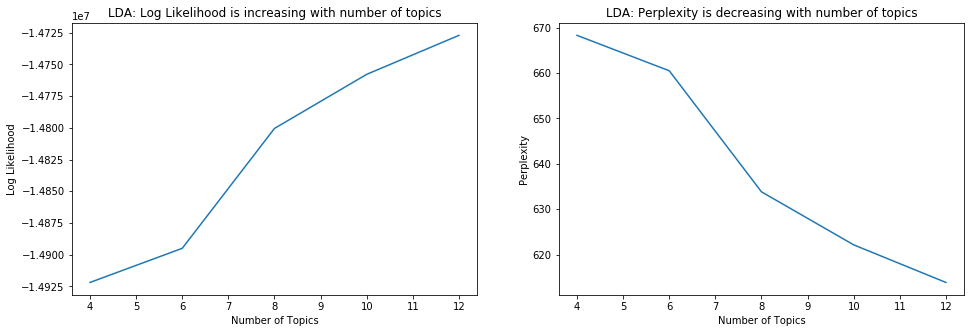

In [26]:
# plot likelihood and perplexity:
p, axes = plt.subplots(1, 2, figsize=(16,5))

p = sns.lineplot(x="ntopics", y='LL', data=results_TF, ax=axes[0])
axes[0].title.set_text('LDA: Log Likelihood is increasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Log Likelihood')

p = sns.lineplot(x="ntopics", y='perplexity', data=results_TF, ax=axes[1])
axes[1].title.set_text('LDA: Perplexity is decreasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Perplexity')

plt.show()

In [25]:
# SAVE ALL THESE OUTPUTS !!! (save the trained LDAs)

for ntopics in all_ntopics:
    # Save to file:
    pkl_filename = '../data/pickle_LDA_TF_' + str(ntopics) + 't.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(results_TF.loc[ntopics, 'LDA'], file)

In [34]:
# 4 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[4, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.102876 -0.075349       1        1  32.348298
2     -0.162138  0.130503       2        1  24.302196
3      0.088061 -0.219865       3        1  23.128012
0      0.176953  0.164710       4        1  20.221493, topic_info=     Category          Freq      Term         Total  loglift  logprob
804   Default  11874.000000    fruits  11874.000000  30.0000  30.0000
346   Default  25677.000000    cherry  25677.000000  29.0000  29.0000
214   Default  26011.000000     black  26011.000000  28.0000  28.0000
1264  Default  29699.000000    palate  29699.000000  27.0000  27.0000
574   Default  27107.000000     drink  27107.000000  26.0000  26.0000
...       ...           ...       ...           ...      ...      ...
165    Topic4   3114.394380  balanced   7246.608970   0.7539  -5.0036
1980   Topic4   2954.532816     years   6615.989294   0.7923  -5.0563
768    Topic4   3376.490196     fresh  12585.011899   0.2828  -4.9228
589    Topic4   3269.801649       dry  14447.436874   0.1126  -4.9549
1671   Topic4   3033.968238     spice  15919.642052  -0.0593  -5.0298

[350 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
21        1  0.126379     acidity
21        2  0.298747     acidity
21        3  0.094271     acidity
21        4  0.480587     acidity
49        4  0.999557  aftertaste
...     ...       ...         ...
1991      1  0.212541       young
1991      2  0.041955       young
1991      3  0.077881       young
1991      4  0.667519       young
1998      1  0.998322         zin

[637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [35]:
# 6 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[6, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.094491  0.029770       1        1  25.704812
3     -0.173237 -0.222870       2        1  17.625113
5     -0.164248  0.243233       3        1  15.596131
2      0.211738 -0.021892       4        1  15.592469
0      0.174839  0.172703       5        1  12.816548
1      0.045400 -0.200943       6        1  12.664926, topic_info=     Category          Freq     Term         Total  loglift  logprob
106   Default  30799.000000   aromas  30799.000000  30.0000  30.0000
21    Default  29239.000000  acidity  29239.000000  29.0000  29.0000
1264  Default  30127.000000   palate  30127.000000  28.0000  28.0000
214   Default  25986.000000    black  25986.000000  27.0000  27.0000
346   Default  25689.000000   cherry  25689.000000  26.0000  26.0000
...       ...           ...      ...           ...      ...      ...
1567   Topic6   1267.352433   savory   4419.563288   0.8172  -5.4348
574    Topic6   1643.075961    drink  26978.768616  -0.7321  -5.1752
893    Topic6   1298.074538     herb   5940.201089   0.5455  -5.4108
1035   Topic6   1386.302945    light  10675.622591   0.0250  -5.3451
1684   Topic6   1258.048216    spicy   5826.616421   0.5335  -5.4422

[489 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
21        1  0.050104  acidity
21        2  0.029925  acidity
21        3  0.310642  acidity
21        4  0.060193  acidity
21        5  0.413688  acidity
...     ...       ...      ...
1996      2  0.011341    zesty
1996      4  0.286764    zesty
1996      5  0.606471    zesty
1996      6  0.094508    zesty
1998      1  0.999300      zin

[1087 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 3, 1, 2])

In [36]:
# 8 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[8, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.076095  0.065119       1        1  17.147212
6      0.010122 -0.118357       2        1  14.027833
3     -0.306990 -0.090776       3        1  13.657466
5     -0.120364  0.275135       4        1  12.457365
7      0.205593 -0.166796       5        1  11.456908
2      0.238015  0.009529       6        1  11.282759
0      0.152138  0.249950       7        1  10.147560
1     -0.102420 -0.223806       8        1   9.822896, topic_info=     Category          Freq       Term         Total  loglift  logprob
106   Default  30858.000000     aromas  30858.000000  30.0000  30.0000
1264  Default  30040.000000     palate  30040.000000  29.0000  29.0000
198   Default  14134.000000      berry  14134.000000  28.0000  28.0000
1784  Default  28364.000000    tannins  28364.000000  27.0000  27.0000
214   Default  25759.000000      black  25759.000000  26.0000  26.0000
...       ...           ...        ...           ...      ...      ...
21     Topic8   1932.853297    acidity  29225.064364  -0.3956  -4.7586
1431   Topic8   1254.720547  raspberry   8172.291369   0.4466  -5.1907
1222   Topic8   1304.043739     offers  10162.764357   0.2672  -5.1521
1684   Topic8   1163.604495      spicy   5843.421312   0.7067  -5.2661
1863   Topic8   1129.765624      touch   6668.508841   0.5451  -5.2956

[602 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
21        1  0.052113  acidity
21        2  0.023473  acidity
21        3  0.068058  acidity
21        4  0.209957  acidity
21        5  0.097382  acidity
...     ...       ...      ...
1996      5  0.580085    zesty
1996      6  0.067991    zesty
1996      7  0.268728    zesty
1996      8  0.066912    zesty
1998      1  0.998796      zin

[1611 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 4, 6, 8, 3, 1, 2])

In [37]:
# 10 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[10, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.119531 -0.193084       1        1  12.483867
5      0.253261  0.193232       2        1  11.514336
3     -0.212099  0.233774       3        1  11.190866
9      0.171079 -0.143841       4        1  11.175473
4      0.236318 -0.027012       5        1  11.149975
6      0.018848 -0.028860       6        1  10.579680
0      0.095368  0.266427       7        1   9.108049
8      0.032869 -0.276893       8        1   8.959492
7     -0.241083 -0.106399       9        1   8.106708
1     -0.235031  0.082656      10        1   5.731554, topic_info=     Category          Freq     Term         Total  loglift  logprob
214   Default  25910.000000    black  25910.000000  30.0000  30.0000
1264  Default  29960.000000   palate  29960.000000  29.0000  29.0000
1193  Default  13480.000000     nose  13480.000000  28.0000  28.0000
1784  Default  28403.000000  tannins  28403.000000  27.0000  27.0000
106   Default  30647.000000   aromas  30647.000000  26.0000  26.0000
...       ...           ...      ...           ...      ...      ...
567   Topic10    820.096917    dried   7109.577974   0.6994  -5.0772
1196  Topic10    746.882575     note   4232.686787   1.1245  -5.1707
1596  Topic10    807.801677    shows   9845.680599   0.3587  -5.0923
475   Topic10    805.707309    crisp  10016.566587   0.3389  -5.0949
1197  Topic10    761.416020    notes  13844.435507  -0.0413  -5.1514

[707 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
21        1  0.149408        acidity
21        2  0.201478        acidity
21        3  0.040002        acidity
21        4  0.004479        acidity
21        5  0.061849        acidity
...     ...       ...            ...
1985      9  0.048253         yellow
1985     10  0.168887         yellow
1987      1  0.003208   yellow fruit
1987      7  0.994400   yellow fruit
1988      7  0.997914  yellow fruits

[2175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 4, 10, 5, 7, 1, 9, 8, 2])

In [38]:
# 12 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[12, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.268567 -0.199237       1        1  11.007408
3     -0.260100 -0.245436       2        1  10.794212
4      0.114839 -0.140537       3        1  10.446757
9     -0.037607 -0.129664       4        1   9.887668
6     -0.052014 -0.225632       5        1   9.569970
0      0.313050  0.039362       6        1   8.496199
2     -0.034858  0.272728       7        1   8.157829
8     -0.095885  0.053464       8        1   7.908196
7     -0.273604 -0.026229       9        1   6.901303
11     0.083843  0.234405      10        1   6.332331
10     0.224904  0.191958      11        1   5.275769
1     -0.251134  0.174818      12        1   5.222358, topic_info=     Category          Freq        Term         Total  loglift  logprob
214   Default  25806.000000       black  25806.000000  30.0000  30.0000
106   Default  30566.000000      aromas  30566.000000  29.0000  29.0000
1264  Default  29948.000000      palate  29948.000000  28.0000  28.0000
91    Default   9950.000000       apple   9950.000000  27.0000  27.0000
21    Default  29376.000000     acidity  29376.000000  26.0000  26.0000
...       ...           ...         ...           ...      ...      ...
1718  Topic12    708.755205  strawberry   4169.871635   1.1801  -5.1301
1264  Topic12   1080.257756      palate  29948.854672  -0.3701  -4.7086
1596  Topic12    812.608814       shows   9869.954805   0.4552  -4.9933
567   Topic12    762.641348       dried   7121.120827   0.7182  -5.0568
1197  Topic12    779.552560       notes  13859.818268   0.0742  -5.0349

[815 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
12        2  0.073440         abound
12        3  0.110160         abound
12        4  0.020400         abound
12        5  0.024480         abound
12        7  0.012240         abound
...     ...       ...            ...
1988      6  0.988943  yellow fruits
1988     10  0.009315  yellow fruits
1989      7  0.219705   yellow peach
1989     10  0.724641   yellow peach
1989     12  0.057817   yellow peach

[2782 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 10, 7, 1, 3, 9, 8, 12, 11, 2])

**Let's try with a few more topics too, as it seems that we did not reach the limits where we have too many of them yet.**

In [39]:
# THIS CHUNK TAKES TIME ! 
time0 = time.time()

all_ntopics = [15, 20] 

results_TF_2 = pd.DataFrame(all_ntopics, columns=['ntopics'], index=all_ntopics)

for ntopics in all_ntopics:
    lda = LatentDirichletAllocation(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )
    # the results are stored in a dataframe, with the number of topics as index:
    results_TF_2.loc[ntopics, 'LDA'] = lda.fit(wine_tf_bigram)
    
    # we store some "metrics": 
    # Log Likelihood: Higher the better
    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    results_TF_2.loc[ntopics, 'LL'] = results_TF_2.loc[ntopics, 'LDA'].score(wine_tf_bigram)
    results_TF_2.loc[ntopics, 'perplexity'] = results_TF_2.loc[ntopics, 'LDA'].perplexity(wine_tf_bigram)

print('Done! It took', time.time()-time0, 'seconds.')


Done! It took 342.2417368888855 seconds.


In [44]:
# append result to previous results:
results_TF = results_TF.append(results_TF_2)

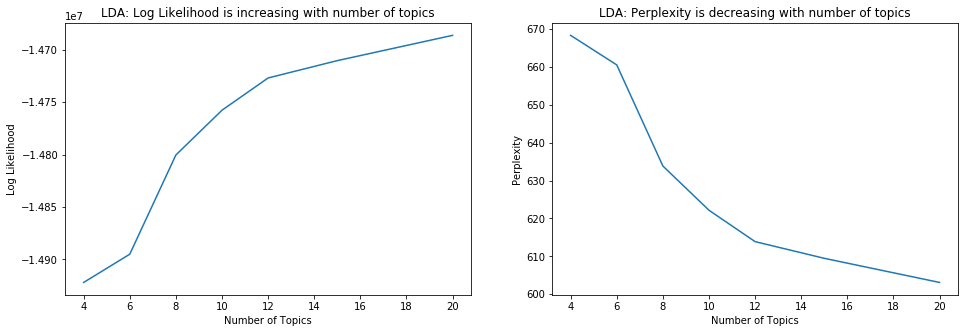

In [45]:
# update plot likelihood and perplexity:
p, axes = plt.subplots(1, 2, figsize=(16,5))

p = sns.lineplot(x="ntopics", y='LL', data=results_TF, ax=axes[0])
axes[0].title.set_text('LDA: Log Likelihood is increasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Log Likelihood')

p = sns.lineplot(x="ntopics", y='perplexity', data=results_TF, ax=axes[1])
axes[1].title.set_text('LDA: Perplexity is decreasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Perplexity')

plt.show()

In [46]:
# 15 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[15, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.215828  0.236587       1        1  10.020010
6     -0.050062  0.021913       2        1   9.046562
12    -0.357977 -0.073369       3        1   8.899855
13    -0.170129  0.034521       4        1   7.773202
14     0.068218 -0.209596       5        1   7.579672
0      0.314490 -0.130807       6        1   7.559465
4      0.037877  0.193283       7        1   7.249043
9     -0.119457  0.238157       8        1   6.494841
8      0.027436  0.307645       9        1   5.900100
7     -0.192299 -0.182764      10        1   5.783744
3     -0.331998  0.109799      11        1   5.562204
2      0.133813 -0.264652      12        1   5.147054
1     -0.102743 -0.295949      13        1   4.814388
10     0.297791  0.067197      14        1   4.276419
11     0.229214 -0.051964      15        1   3.893442, topic_info=     Category          Freq     Term         Total  loglift  logprob
214   Default  25965.000000    black  25965.000000  30.0000  30.0000
106   Default  30463.000000   aromas  30463.000000  29.0000  29.0000
1784  Default  28407.000000  tannins  28407.000000  28.0000  28.0000
91    Default  10098.000000    apple  10098.000000  27.0000  27.0000
1264  Default  30007.000000   palate  30007.000000  26.0000  26.0000
...       ...           ...      ...           ...      ...      ...
966   Topic15    661.504210    juicy   8219.644007   0.7261  -4.9054
1193  Topic15    711.113699     nose  13665.614609   0.2901  -4.8331
768   Topic15    700.877448    fresh  12626.185084   0.3547  -4.8476
91    Topic15    675.985214    apple  10098.659757   0.5419  -4.8838
21    Topic15    732.740581  acidity  29252.832988  -0.4411  -4.8031

[983 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
21        1  0.173111       acidity
21        2  0.011657       acidity
21        3  0.051790       acidity
21        4  0.028408       acidity
21        5  0.095341       acidity
...     ...       ...           ...
1989     15  0.110006  yellow peach
1994      3  0.997005    youthfully
1998      7  0.006254           zin
1998      8  0.185114           zin
1998      9  0.807997           zin

[3769 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 13, 14, 15, 1, 5, 10, 9, 8, 4, 3, 2, 11, 12])

In [47]:
# 20 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[20, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.336611  0.146469       1        1  7.633542
17     0.182606 -0.273130       2        1  7.620799
13    -0.054022  0.235413       3        1  6.938353
16    -0.200582  0.205320       4        1  6.631591
19    -0.052027 -0.349331       5        1  5.933824
14    -0.203988 -0.090252       6        1  5.457440
7     -0.031438  0.349583       7        1  5.257161
6      0.093126  0.154650       8        1  5.213725
15    -0.064255  0.086894       9        1  5.208862
3      0.276116  0.247123      10        1  5.203003
4      0.057045  0.011322      11        1  5.107179
9      0.121831  0.256706      12        1  5.059968
5      0.087190 -0.343584      13        1  4.795199
8     -0.313614  0.131357      14        1  3.798951
0     -0.023164 -0.202236      15        1  3.548425
11    -0.190800 -0.209288      16        1  3.547962
2     -0.293552 -0.003252      17        1  3.525945
10    -0.322184 -0.148688      18        1  3.497394
1      0.246007 -0.047729      19        1  3.030996
18     0.349095 -0.157346      20        1  2.989681, topic_info=     Category          Freq    Term         Total  loglift  logprob
214   Default  25915.000000   black  25915.000000  30.0000  30.0000
1211  Default  15873.000000     oak  15873.000000  29.0000  29.0000
106   Default  30442.000000  aromas  30442.000000  28.0000  28.0000
91    Default  10020.000000   apple  10020.000000  27.0000  27.0000
1264  Default  29849.000000  palate  29849.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
177   Topic20    757.831506  barrel   3841.598852   1.8868  -4.5053
1991  Topic20    664.346939   young   3965.268201   1.7235  -4.6370
60    Topic20    610.728694   aging   4907.639869   1.4261  -4.7212
1833  Topic20    504.395220   tight   4345.980214   1.3564  -4.9124
208   Topic20    369.109520     bit   4743.366026   0.9566  -5.2247

[1217 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
21        1  0.050913  acidity
21        2  0.076881  acidity
21        3  0.024808  acidity
21        4  0.026514  acidity
21        5  0.212728  acidity
...     ...       ...      ...
1999      9  0.003374    zippy
1999     14  0.037111    zippy
1999     16  0.053980    zippy
1999     17  0.037111    zippy
1999     18  0.040485    zippy

[5460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 18, 14, 17, 20, 15, 8, 7, 16, 4, 5, 10, 6, 9, 1, 12, 3, 11, 2, 19])

**We should try even more topics!**

In [48]:
# THIS CHUNK TAKES TIME ! 
time0 = time.time()

all_ntopics = [25, 30, 40, 50] 

results_TF_3 = pd.DataFrame(all_ntopics, columns=['ntopics'], index=all_ntopics)

for ntopics in all_ntopics:
    lda = LatentDirichletAllocation(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )
    # the results are stored in a dataframe, with the number of topics as index:
    results_TF_3.loc[ntopics, 'LDA'] = lda.fit(wine_tf_bigram)
    
    # we store some "metrics": 
    # Log Likelihood: Higher the better
    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    results_TF_3.loc[ntopics, 'LL'] = results_TF_3.loc[ntopics, 'LDA'].score(wine_tf_bigram)
    results_TF_3.loc[ntopics, 'perplexity'] = results_TF_3.loc[ntopics, 'LDA'].perplexity(wine_tf_bigram)

print('Done! It took', time.time()-time0, 'seconds.')


Done! It took 688.8535389900208 seconds.


In [50]:
# append result to previous results:
results_TF = results_TF.append(results_TF_3)

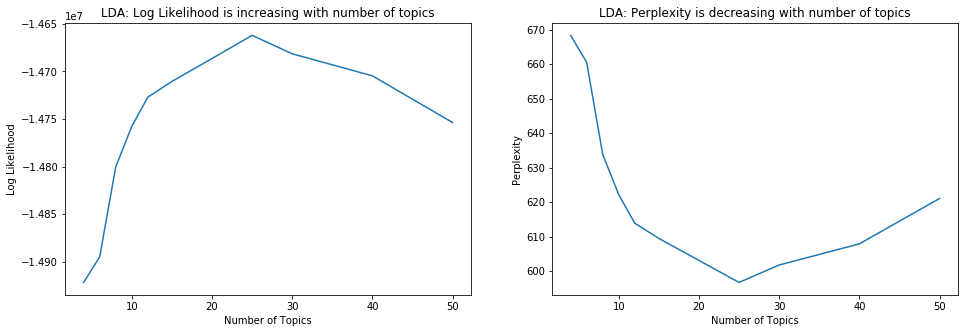

In [51]:
# update plot likelihood and perplexity:
p, axes = plt.subplots(1, 2, figsize=(16,5))

p = sns.lineplot(x="ntopics", y='LL', data=results_TF, ax=axes[0])
axes[0].title.set_text('LDA: Log Likelihood is increasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Log Likelihood')

p = sns.lineplot(x="ntopics", y='perplexity', data=results_TF, ax=axes[1])
axes[1].title.set_text('LDA: Perplexity is decreasing with number of topics')
p.set(xlabel='Number of Topics', ylabel='Perplexity')

plt.show()

**Ah ah ! There is an peak reached around 25 topics! Let's have a look:**

In [52]:
# 25 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[25, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.225028 -0.237341       1        1  6.388698
13    -0.041007  0.189496       2        1  6.294701
12    -0.231072  0.308263       3        1  6.143489
22     0.351536 -0.002877       4        1  5.834475
3     -0.178003  0.333985       5        1  5.094493
7     -0.007637  0.312016       6        1  4.904814
14     0.266267  0.004730       7        1  4.516403
15     0.058780 -0.000792       8        1  4.452331
19     0.059962 -0.387555       9        1  4.344883
4     -0.159422  0.019604      10        1  3.961901
21     0.149900  0.256638      11        1  3.923901
24    -0.286602 -0.066752      12        1  3.764766
5     -0.144152 -0.320617      13        1  3.747944
0     -0.017051 -0.305783      14        1  3.617690
9     -0.324872  0.111243      15        1  3.542971
16    -0.103372 -0.086177      16        1  3.500633
6      0.085650  0.145665      17        1  3.441834
20    -0.158465  0.101557      18        1  3.394978
10     0.182097 -0.228728      19        1  3.342769
8      0.295300 -0.221787      20        1  3.315802
1      0.271083 -0.041804      21        1  3.256357
11     0.057606 -0.248385      22        1  2.743496
23     0.342554  0.203113      23        1  2.543015
18    -0.404436 -0.202268      24        1  1.981978
2      0.160385  0.364557      25        1  1.945678, topic_info=     Category          Freq    Term         Total  loglift  logprob
1442  Default  18789.000000     red  18789.000000  30.0000  30.0000
214   Default  26066.000000   black  26066.000000  29.0000  29.0000
1211  Default  16031.000000     oak  16031.000000  28.0000  28.0000
106   Default  30342.000000  aromas  30342.000000  27.0000  27.0000
574   Default  26936.000000   drink  26936.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
91    Topic25    463.629792   apple   9639.606740   0.9050  -4.5672
1962  Topic25    398.168988    wood   6249.339823   1.1862  -4.7194
711   Topic25    402.736151  finish  25073.179475  -0.1917  -4.7080
1264  Topic25    374.920858  palate  29624.047069  -0.4301  -4.7795
1501  Topic25    370.945926    ripe  23809.693688  -0.2222  -4.7902

[1442 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         3  0.059888  2015
0         5  0.209607  2015
0        16  0.726140  2015
1         3  0.249440  2016
1         5  0.246699  2016
...     ...       ...   ...
1995      9  0.154859  zest
1995     14  0.043100  zest
1995     20  0.032576  zest
1995     21  0.121783  zest
1995     22  0.027063  zest

[7052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 14, 13, 23, 4, 8, 15, 16, 20, 5, 22, 25, 6, 1, 10, 17, 7, 21, 11, 9, 2, 12, 24, 19, 3])

In [53]:
# 30 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[30, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.095372 -0.041509       1        1  5.679650
12     0.326652 -0.233965       2        1  5.384291
17    -0.306904 -0.183019       3        1  5.237701
3      0.329181 -0.194638       4        1  4.951114
22     0.034397  0.330765       5        1  4.863062
7      0.302429 -0.006017       6        1  4.356644
19    -0.339599  0.204894       7        1  4.062473
15     0.018735  0.067624       8        1  3.814985
16    -0.138543 -0.109350       9        1  3.658889
5     -0.324802 -0.087932      10        1  3.645193
14     0.033219  0.227748      11        1  3.575728
4     -0.052416 -0.180057      12        1  3.431666
9     -0.019186 -0.368289      13        1  3.226884
29     0.188008 -0.214551      14        1  3.115482
20     0.068511 -0.174397      15        1  3.027457
10    -0.221587  0.220247      16        1  2.916991
8     -0.149748  0.340782      17        1  2.836610
0     -0.258695  0.056880      18        1  2.799453
28     0.070644 -0.342842      19        1  2.784754
18    -0.415814 -0.035058      20        1  2.741177
6      0.190523 -0.015686      21        1  2.727276
26    -0.122831 -0.291875      22        1  2.572203
1      0.109973  0.398258      23        1  2.534184
24    -0.199517 -0.303538      24        1  2.533020
27    -0.073155  0.227051      25        1  2.419503
2      0.138731  0.274430      26        1  2.387552
11    -0.305751  0.093741      27        1  2.346429
21     0.397485 -0.008345      28        1  2.248458
23     0.352773  0.237854      29        1  2.132185
25     0.271914  0.110794      30        1  1.988987, topic_info=     Category          Freq    Term         Total  loglift  logprob
1442  Default  18618.000000     red  18618.000000  30.0000  30.0000
106   Default  30350.000000  aromas  30350.000000  29.0000  29.0000
214   Default  26103.000000   black  26103.000000  28.0000  28.0000
346   Default  25715.000000  cherry  25715.000000  27.0000  27.0000
1264  Default  29841.000000  palate  29841.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
768   Topic30    376.705979   fresh  12534.871415   0.4127  -4.7968
1642  Topic30    359.223302    soft  11209.640747   0.4770  -4.8443
1635  Topic30    327.086033  smooth   5872.707376   1.0297  -4.9380
106   Topic30    358.414166  aromas  30350.774326  -0.5213  -4.8466
1264  Topic30    311.896918  palate  29841.472521  -0.6434  -4.9856

[1704 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.041401   2015
0         4  0.237116   2015
0         9  0.715112   2015
2         2  0.378491   2017
2         4  0.026688   2017
...     ...       ...    ...
1999     16  0.006899  zippy
1999     17  0.037942  zippy
1999     21  0.034493  zippy
1999     25  0.003449  zippy
1999     26  0.003449  zippy

[9364 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 13, 18, 4, 23, 8, 20, 16, 17, 6, 15, 5, 10, 30, 21, 11, 9, 1, 29, 19, 7, 27, 2, 25, 28, 3, 12, 22, 24, 26])

In [54]:
# 40 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[40, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.073252  0.398069       1        1  5.187511
3      0.150708  0.370384       2        1  4.683726
31     0.064192  0.130738       3        1  4.207684
38    -0.211751 -0.219671       4        1  4.024381
17     0.089447 -0.335993       5        1  3.444492
39     0.037649 -0.284523       6        1  3.208101
22    -0.292214  0.241798       7        1  3.055044
7     -0.003895  0.324722       8        1  2.974137
19    -0.370369  0.025288       9        1  2.963813
35     0.042905 -0.042611      10        1  2.850006
11    -0.229963  0.137551      11        1  2.845592
36     0.182059  0.252552      12        1  2.787144
4      0.203314 -0.056574      13        1  2.778256
13     0.159286  0.033511      14        1  2.645838
25     0.189676  0.164414      15        1  2.640123
34    -0.319696 -0.127007      16        1  2.634004
20     0.224801 -0.146343      17        1  2.509504
26     0.189363 -0.240515      18        1  2.494123
29     0.324565  0.189483      19        1  2.314227
6      0.021848  0.244093      20        1  2.279654
15     0.035020 -0.137065      21        1  2.272453
0     -0.238933 -0.045937      22        1  2.172054
14    -0.180562  0.220246      23        1  2.132231
2     -0.237461  0.322546      24        1  2.071109
8     -0.124865 -0.051603      25        1  2.040681
5     -0.333016 -0.217403      26        1  2.035716
37     0.067182 -0.385285      27        1  1.909059
18    -0.411485 -0.007860      28        1  1.907358
21     0.290699  0.298789      29        1  1.879159
10    -0.151061 -0.334744      30        1  1.869217
32    -0.210005 -0.322584      31        1  1.864091
30    -0.050106 -0.364127      32        1  1.863291
1     -0.168984  0.386433      33        1  1.839930
16     0.361602 -0.090633      34        1  1.813804
23     0.346725  0.048212      35        1  1.780726
27    -0.133439  0.112415      36        1  1.761230
24     0.363244  0.138594      37        1  1.680730
9      0.365238 -0.198055      38        1  1.664735
33    -0.414861 -0.094655      39        1  1.642962
28     0.299890 -0.336648      40        1  1.272108, topic_info=     Category          Freq    Term         Total  loglift  logprob
1442  Default  18653.000000     red  18653.000000  30.0000  30.0000
214   Default  25838.000000   black  25838.000000  29.0000  29.0000
106   Default  30339.000000  aromas  30339.000000  28.0000  28.0000
346   Default  25611.000000  cherry  25611.000000  27.0000  27.0000
574   Default  26911.000000   drink  26911.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
1898  Topic40    252.607780  valley   2071.102639   2.2605  -4.7495
1211  Topic40    382.241404     oak  15792.953267   0.6432  -4.3353
327   Topic40    225.380156   cedar   2904.506992   1.8083  -4.8635
651   Topic40    170.862267  estate   2771.626243   1.5782  -5.1405
1642  Topic40    178.470104    soft  11134.945313   0.2311  -5.0969

[2127 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.029590   2015
0         2  0.236718   2015
0        27  0.266307   2015
0        34  0.462339   2015
1         1  0.188730   2016
...     ...       ...    ...
1999     24  0.034179  zippy
1999     30  0.006836  zippy
1999     31  0.030761  zippy
1999     32  0.006836  zippy
1999     39  0.037597  zippy

[12902 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 32, 39, 18, 40, 23, 8, 20, 36, 12, 37, 5, 14, 26, 35, 21, 27, 30, 7, 16, 1, 15, 3, 9, 6, 38, 19, 22, 11, 33, 31, 2, 17, 24, 28, 25, 10, 34, 29])

In [55]:
# 50 topics:
pyLDAvis.sklearn.prepare(results_TF.loc[50, 'LDA'], wine_tf_bigram, tf_bigram_vectorizer, mds='mmds') # or mds='PCoA'

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.136490  0.383721       1        1  5.017279
3      0.074145  0.402953       2        1  4.608359
17    -0.330004 -0.101706       3        1  3.673536
31     0.095085  0.205028       4        1  3.437351
7      0.297269  0.185233       5        1  3.047960
19     0.102985 -0.341607       6        1  3.028782
34    -0.384501 -0.064023       7        1  2.926253
38    -0.327853 -0.189207       8        1  2.907756
39    -0.311775  0.035293       9        1  2.707911
36     0.010247  0.304475      10        1  2.477549
14     0.253773 -0.148186      11        1  2.400898
45     0.044771  0.086693      12        1  2.261741
43    -0.090624  0.112938      13        1  2.240499
48     0.399233 -0.068863      14        1  2.144055
22     0.315854 -0.215291      15        1  2.127229
13    -0.024656  0.184416      16        1  2.096087
42     0.251331 -0.083618      17        1  2.082117
46     0.237919  0.239276      18        1  2.046236
0     -0.013227 -0.227117      19        1  1.986955
18    -0.024268 -0.419934      20        1  1.985373
10    -0.077534 -0.322154      21        1  1.933517
41     0.350297 -0.010996      22        1  1.913110
21     0.219475  0.339474      23        1  1.892268
29    -0.032012  0.341611      24        1  1.855637
26    -0.129249 -0.000451      25        1  1.854847
35    -0.196285  0.194724      26        1  1.833546
1      0.434264  0.052766      27        1  1.814828
5     -0.382536 -0.132753      28        1  1.760422
23     0.333863  0.261676      29        1  1.724172
44    -0.256325 -0.237951      30        1  1.653392
32    -0.109067 -0.375998      31        1  1.630754
49     0.279260  0.117907      32        1  1.624221
4     -0.202818  0.078982      33        1  1.595298
16    -0.016071 -0.072874      34        1  1.586013
6      0.176358  0.106904      35        1  1.568250
8      0.354348 -0.174894      36        1  1.538222
9     -0.122981  0.415633      37        1  1.518902
37    -0.208316 -0.091477      38        1  1.428703
27     0.147566 -0.218171      39        1  1.413340
20    -0.150208 -0.240330      40        1  1.371764
24    -0.227299  0.326382      41        1  1.361963
30    -0.394130  0.092976      42        1  1.360178
28    -0.294694 -0.379304      43        1  1.251374
11     0.030464 -0.315166      44        1  1.219289
33    -0.351047  0.132242      45        1  1.186976
47    -0.350769  0.265368      46        1  1.183076
25    -0.163643  0.387036      47        1  1.061371
15     0.127370 -0.055718      48        1  1.030519
2      0.160493 -0.410784      49        1  0.886691
40     0.339032 -0.355132      50        1  0.743431, topic_info=     Category          Freq    Term         Total  loglift  logprob
1442  Default  18560.000000     red  18560.000000  30.0000  30.0000
346   Default  25751.000000  cherry  25751.000000  29.0000  29.0000
214   Default  25809.000000   black  25809.000000  28.0000  28.0000
256   Default  10750.000000  bodied  10750.000000  27.0000  27.0000
504   Default  10827.000000    dark  10827.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
768   Topic50     78.119619   fresh  12611.189271  -0.1824  -5.3859
1197  Topic50     78.768458   notes  13881.674246  -0.2702  -5.3776
777   Topic50     89.433954   fruit  40894.883188  -1.2236  -5.2507
711   Topic50     74.593313  finish  25345.314245  -0.9266  -5.4321
1264  Topic50     65.726120  palate  29786.520059  -1.2147  -5.5587

[2499 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.003558   2015
0         2  0.131657   2015
0        38  0.861105   2015
1         1  0.165600   2016
1         2  0.269767   2016
...     ...       ...    ...
1999     31  0.006742  zippy
1999     32  0.010113  zippy
1999     35  0.003371  zippy
1999     42  0.013484  zippy

In [56]:
# SAVE ALL THESE OUTPUTS !!! (save the trained LDAs)

for ntopics in all_ntopics:
    # Save to file:
    pkl_filename = '../data/pickle_LDA_TF_' + str(ntopics) + 't.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(results_TF.loc[ntopics, 'LDA'], file)

### Discussion

We could not identify topics that are clearly representing the "style" of writing, but it could be that those topics reflect (in part) the authors... They could of course also represent true underlying tastes in the different wines, i.e. different styles of wines.   

Some words are well represented in a few topics only, like "bodied", "chocolate" or "apple", whereas other are more spread in all the topics, like "fruit" (but not "fruits"!), or "ripe".  